# Exploratory Data Analysis (EDA) of Financial News Dataset

This notebook performs EDA on the financial news dataset to uncover patterns, trends, and insights relevant to financial analytics and predictive modeling.

**Tasks covered:**
- Descriptive statistics (headline length, article counts per publisher, publication date trends)
- Text analysis (topic modeling, keyword extraction)
- Time series analysis (publication frequency, event spikes)
- Publisher analysis (activity, domain analysis)

In [1]:
# Install missing libraries if needed (uncomment if running for the first time)
!pip install wordcloud nltk scikit-learn seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
sns.set(style='whitegrid')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load the dataset
df = pd.read_csv('../data/raw_analyst_ratings.csv', usecols=['headline','url','publisher','date','stock'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


Headline Length Statistics:


count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64

Top 10 Publishers by Article Count:


publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64

Top 10 Stocks by Article Count:


stock
ZX      10
A       10
AA      10
AAC     10
ZUMZ    10
AAL     10
AAMC    10
AAME    10
AAN     10
AAOI    10
Name: count, dtype: int64

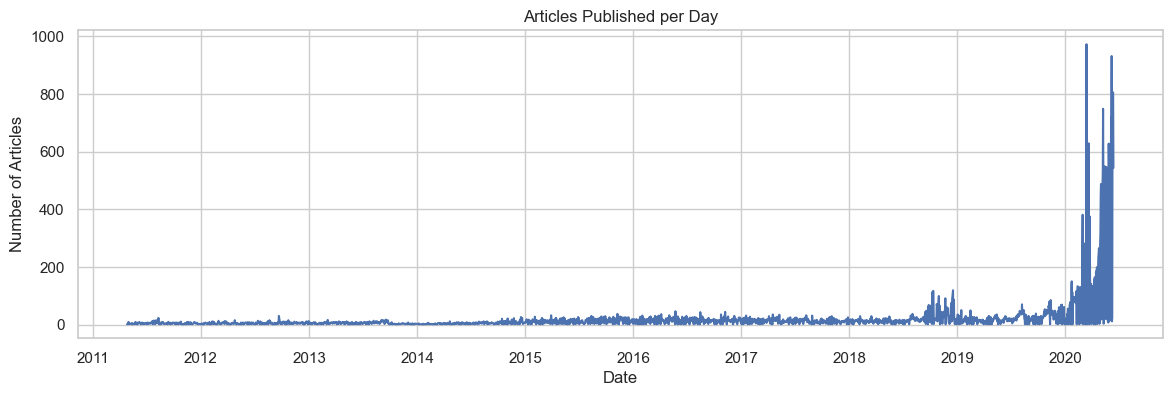

In [5]:
# Headline length
df['headline_length'] = df['headline'].astype(str).apply(len)
print('Headline Length Statistics:')
display(df['headline_length'].describe())

# Article count per publisher
publisher_counts = df['publisher'].value_counts()
print('Top 10 Publishers by Article Count:')
display(publisher_counts.head(10))

# Articles per stock
stock_counts = df['stock'].value_counts()
print('Top 10 Stocks by Article Count:')
display(stock_counts.head(10))

# Publication date trends
df['date_only'] = df['date'].dt.date
daily_counts = df.groupby('date_only').size()
plt.figure(figsize=(14,4))
daily_counts.plot()
plt.title('Articles Published per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

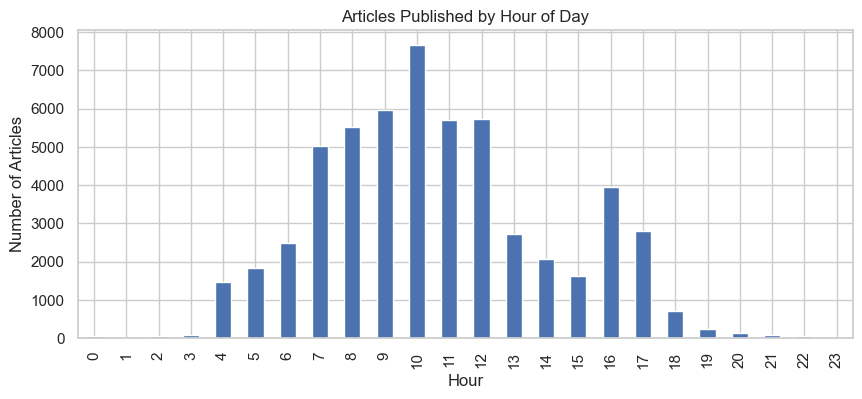

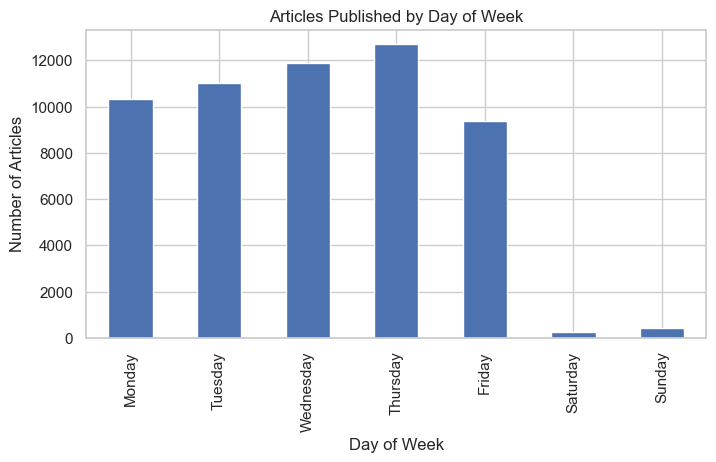

In [6]:
# Publication frequency by hour
df['hour'] = df['date'].dt.hour
hourly_counts = df.groupby('hour').size()
plt.figure(figsize=(10,4))
hourly_counts.plot(kind='bar')
plt.title('Articles Published by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.show()

# Weekly trends
df['weekday'] = df['date'].dt.day_name()
weekday_counts = df['weekday'].value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(8,4))
weekday_counts.plot(kind='bar')
plt.title('Articles Published by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Articles')
plt.show()

Top Publisher Domains:


publisher_domain
benzinga.com    1196
gmail.com          3
Name: count, dtype: int64

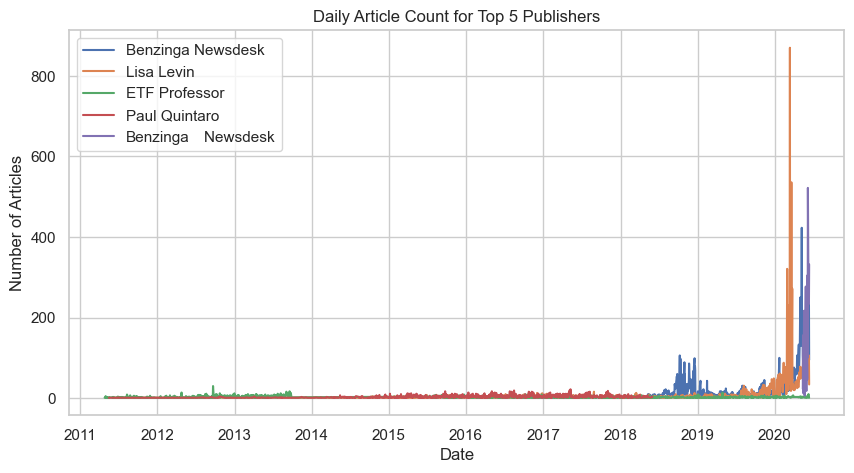

In [7]:
# Publisher domain analysis (if publisher is an email)
df['publisher_domain'] = df['publisher'].astype(str).apply(lambda x: x.split('@')[-1] if '@' in x else None)
domain_counts = df['publisher_domain'].value_counts().head(10)
print('Top Publisher Domains:')
display(domain_counts)

# Compare publisher activity
top_publishers = publisher_counts.head(5).index
plt.figure(figsize=(10,5))
for pub in top_publishers:
    pub_counts = df[df['publisher'] == pub].groupby('date_only').size()
    plt.plot(pub_counts.index, pub_counts.values, label=pub)
plt.legend()
plt.title('Daily Article Count for Top 5 Publishers')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

Most Common Keywords:


,Keyword,Count
0,stocksthathit52weeklowsonthursday,1764
1,stocksthathit52weeklowsonfriday,713
2,stocksthathit52weekhighsonfriday,540
3,stocksthathit52weekhighsontuesday,510
4,stocksthathit52weekhighsonwednesday,470
5,stocksthathit52weeklowsonwednesday,421
6,stocksthathit52weekhighsonthursday,412
7,stocksthathit52weeklowsonmonday,397
8,stocksthathit52weekhighsonmonday,377
9,stocksthathit52weeklowsontuesday,224


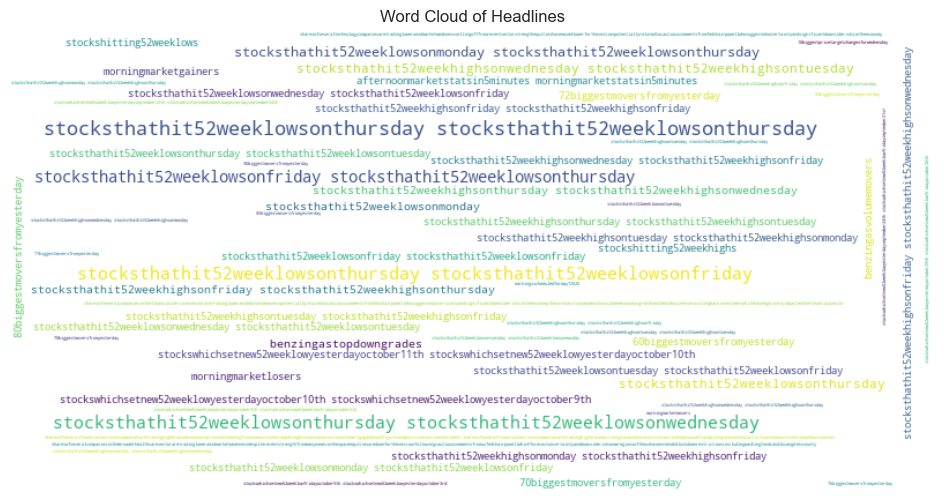

Topic #1:
['stocksthathit52weekhighsonfriday', 'morningmarketgainers', '90biggestmoversfromyesterday', 'stockshitting52weeklows', 'stockswhichsetnew52weeklowyesterdayoctober9th', '72biggestmoversfromyesterday', 'stockswhichsetnew52weeklowyesterdaythursdec132018', 'stockswhichsetnew52weeklowyesterdayoctober22nd', 'morningmarketmovers', 'sharesofseveralindustrialcompaniesaretradinghigherinsympathywiththeoverallmarketasequitiesrallyoncoronavirusvaccinehopesaswellasapickupineconomicactivityassomeusstatesreopenbusinesses']

Topic #2:
['stocksthathit52weeklowsonwednesday', 'stocksthathit52weekhighsonthursday', 'stocksthathit52weeklowsonmonday', 'stocksthathit52weekhighsonmonday', 'morningmarketlosers', 'stockswhichsetnew52weeklowyesterdaytuesnov202018', 'stockswhichsetnew52weeklowyesterdaytuesdec182018', 'sharesofseveralfinancialservicescompaniesaretradinghigheramideconomicoptimismstemmingfromsomeusstatesreopeningbusinessesanincreaseinmortgagedemandfiguresandpositivevaccinesentiment', 'stock

In [8]:
# Preprocess headlines
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\\s]', '', text)  # Use raw string for regex
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

df['clean_headline'] = df['headline'].astype(str).apply(preprocess)

# Most common keywords
all_words = ' '.join(df['clean_headline']).split()
word_freq = Counter(all_words)
print('Most Common Keywords:')
display(pd.DataFrame(word_freq.most_common(20), columns=['Keyword','Count']))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Headlines')
plt.show()

# Topic Modeling (LDA)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['clean_headline'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f'Topic #{idx+1}:')
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-top_n:][::-1]])
        print()
print_topics(lda, vectorizer)